In [185]:
import torch

In [186]:
from sklearn.preprocessing import MinMaxScaler

In [187]:
import pandas as pd

In [188]:
df = pd.read_csv("./q2_dataset.csv")

In [189]:
df.columns = df.columns.str.strip()

feat_names = ['Volume', 'Open', 'High', 'Low']
target_name = 'Open'
df = df[feat_names]
scalers = {}
for column in df.columns:
    scalers[column] = MinMaxScaler(feature_range=(-1, 1))
    df[column] = scalers[column].fit_transform(df[column].values.reshape(-1,1))


In [190]:
scalers

{'Volume': MinMaxScaler(feature_range=(-1, 1)),
 'Open': MinMaxScaler(feature_range=(-1, 1)),
 'High': MinMaxScaler(feature_range=(-1, 1)),
 'Low': MinMaxScaler(feature_range=(-1, 1))}

In [191]:
import numpy as np
def split_data(df, feat_names,  target_name, window):
    data = df[feat_names]
    data[f"{target_name}_target"] = df[target_name] 
    data = data.to_numpy()

    windows = []
    for i in range(len(data) - window):
        windows.append(data[i: i + window, :-1].reshape(1, -1))
    
    windows = np.array(windows)

    x = windows[1:, :]
    y = data[:len(data) - window -1, -1].reshape(-1, 1)
    
    
    split = 0.7
    train_set_size = int(len(windows) * split)
    
    x_train = x[:train_set_size, :, :]
    y_train = y[:train_set_size]
    
    x_test = x[train_set_size:, :, :]
    y_test = y[train_set_size:]
    return x_train, y_train, x_test, y_test

In [192]:
window = 3
x_train, y_train, x_test, y_test = split_data(df, feat_names, target_name, window)

print("shifted train x", x_train.shape)
print("shifted train y", y_train.shape)

print("shifted test x", x_test.shape)
print("shifted test y", y_test.shape)

shifted train x (879, 1, 12)
shifted train y (879, 1)
shifted test x (376, 1, 12)
shifted test y (376, 1)


In [193]:
import torch
import torch.nn as nn

def to_tensor(np_array):
    return torch.from_numpy(np_array).type(torch.Tensor)
x_train = to_tensor(x_train)
x_test = to_tensor(x_test)

y_train_lstm = to_tensor(y_train)
y_test_lstm = to_tensor(y_test)

In [213]:
input_dim = 12
hidden_dim = 200
num_layers = 2
output_dim = 1
num_epochs = 200

In [214]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [215]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
mse = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

import time
losses = []
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = mse(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss)


Epoch  0 MSE:  0.21975871920585632
Epoch  1 MSE:  0.1325359344482422
Epoch  2 MSE:  0.07864128053188324
Epoch  3 MSE:  0.0789056122303009
Epoch  4 MSE:  0.0258888378739357
Epoch  5 MSE:  0.016666743904352188
Epoch  6 MSE:  0.014348844066262245
Epoch  7 MSE:  0.012995009310543537
Epoch  8 MSE:  0.019407184794545174
Epoch  9 MSE:  0.017370812594890594
Epoch  10 MSE:  0.006720964331179857
Epoch  11 MSE:  0.0036188990343362093
Epoch  12 MSE:  0.009712512604892254
Epoch  13 MSE:  0.012898254208266735
Epoch  14 MSE:  0.01032166089862585
Epoch  15 MSE:  0.008250326849520206
Epoch  16 MSE:  0.008150208741426468
Epoch  17 MSE:  0.005598363932222128
Epoch  18 MSE:  0.002698546275496483
Epoch  19 MSE:  0.0028044250793755054
Epoch  20 MSE:  0.004370374605059624
Epoch  21 MSE:  0.0051407888531684875
Epoch  22 MSE:  0.004807060118764639
Epoch  23 MSE:  0.00415319437161088
Epoch  24 MSE:  0.003607983235269785
Epoch  25 MSE:  0.0029870045837014914
Epoch  26 MSE:  0.0025428759399801493
Epoch  27 MSE:  

In [216]:
y_train_pred_inverse = pd.DataFrame(scalers["Open"].inverse_transform(y_train_pred.detach().numpy()))
y_train_lstm_inverse = pd.DataFrame(scalers["Open"].inverse_transform(y_train_lstm.detach().numpy()))

Text(0, 0.5, 'Open Price')

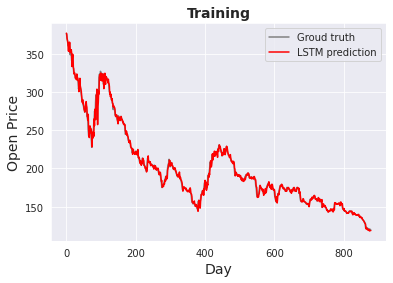

In [219]:
import seaborn as sns
import matplotlib.pyplot as plt   

fig = plt.figure()

ax = sns.lineplot(x=y_train_pred_inverse.index, y=y_train_pred_inverse[0], label="Groud truth", color='grey')
ax = sns.lineplot(x=y_train_lstm_inverse.index, y=y_train_lstm_inverse[0], label="LSTM prediction", color='red')
ax.set_title('Training', size = 14, fontweight='bold')
ax.set_xlabel("Day", size = 14)
ax.set_ylabel("Open Price", size = 14)

In [220]:
y_test_pred = model(x_test)

In [221]:
y_test_pred_inverse = pd.DataFrame(scalers["Open"].inverse_transform(y_test_pred.detach().numpy()))
y_test_lstm_inverse = pd.DataFrame(scalers["Open"].inverse_transform(y_test_lstm.detach().numpy()))
loss = mse(to_tensor(y_test_pred_inverse[0].to_numpy()), to_tensor(y_test_lstm_inverse[0].to_numpy()))
print(loss)

tensor(13.7184)


[Text(-50.0, 0, ''),
 Text(0.0, 0, ''),
 Text(50.0, 0, ''),
 Text(100.0, 0, ''),
 Text(150.0, 0, ''),
 Text(200.0, 0, ''),
 Text(250.0, 0, ''),
 Text(300.0, 0, ''),
 Text(350.0, 0, ''),
 Text(400.0, 0, '')]

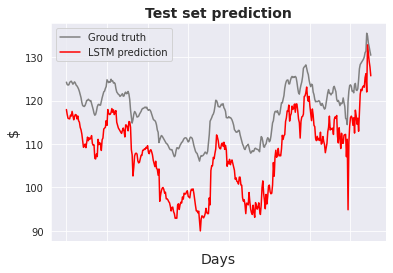

In [212]:
fig = plt.figure()

ax = sns.lineplot(x = y_test_pred_inverse.index, y = y_test_pred_inverse[0], label="Groud truth", color='grey')
ax = sns.lineplot(x = y_test_lstm_inverse.index, y = y_test_lstm_inverse[0], label="LSTM prediction", color='red')
ax.set_title('Test set prediction', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("$", size = 14)
ax.set_xticklabels('', size=10)